In [27]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Import pickled feature data

In [47]:
data = pd.read_pickle('data/feature_engineering.pkl')

In [48]:
data.head()

,id,hour_created,weekday_created,photo_exists,tweet_sentiment,retweets_per_followers,favs_per_followers,rate_all_caps,retweet_count,favorite_count,text_length,target
0,9.529341e+17,16,0,1,1,0.000743,0.002601,0.000000,28,98,203,1
1,9.533119e+17,17,1,1,1,0.000637,0.001805,0.000000,24,68,202,1
2,9.533464e+17,19,1,0,1,0.000212,0.000557,0.060606,8,21,243,1
3,9.536457e+17,15,2,0,1,0.000610,0.003901,0.000000,23,147,61,1
4,9.536777e+17,17,2,0,1,0.000478,0.001327,0.037037,18,50,220,1


In [49]:
y = data.pop('target')
X = data.drop(['id'], axis=1)

In [50]:
y = np.array([int(i) for i in y])

In [51]:
# Generate a confusion matrix plot
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
def find_auc(y_test, y_score):
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot([0,1],[0,1]) # this is our baseline
    plt.plot(fpr, tpr) # this is our ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    print('AUC: ', roc_auc)

In [ ]:
def cross_validation_kfold(features, target, num_folds, model, scale=True):
    """
    Takes in feature set, target, model and number of folds to evaluate the in and out of sample error
    Returns the train and validation errors as defined by AUC Score
    """
    K = num_folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    if len(np.shape(features))==1:
        features = pd.DataFrame(np.array(features).reshape(-1,1))
    
    for train_index, val_index in kf.split(features, target):
        
        # split data
        X_train, X_val = features.loc[train_index], features.loc[val_index]
        y_train, y_val = target[train_index], target[val_index]
        
        # calculate errors
        train_rmse, train_adj_r, validation_rmse, validation_adj_r = calc_metrics(X_train = X_train, 
                                                                                  y_train = y_train, 
                                                                                  X_test = X_val, 
                                                                                  y_test = y_val, 
                                                                                  model = model)


        # append to appropriate list
        train_rmse_l.append(train_rmse)
        train_adj_r_l.append(train_adj_r)
        validation_rmse_l.append(validation_rmse)
        validation_adj_r_l.append(validation_adj_r)
        
        
    # generate report    
    pretty_print_stats(train_rmse=np.mean(train_rmse_l), 
                       train_adj_r=np.mean(train_adj_r_l), 
                       validation_rmse=np.mean(validation_rmse_l), 
                       validation_adj_r=np.mean(validation_adj_r_l))

In [53]:
def train_score(classifier, x, y):
    
    # split data into to training and test sets
    xtrain, xtest, ytrain, ytest = train_test_split(x, y,test_size=0.2, random_state=42)
    ytrain = np.ravel(ytrain)
    
    # fit a model
    clf = classifier.fit(xtrain, ytrain)
    
    # score the model (accuracy)
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    # create a confusion matrix
    y_true = ytest
    y_pred = clf.predict(xtest)
    
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

    cm = confusion_matrix(y_true, y_pred, labels=None)
    # plot the confusion matrix

    print ('\n')
    plt.figure()
    plot_confusion_matrix(cm)
    plt.show()
    
    print('\n Feature Importance')
    for i in zip(list(X), clf.feature_importances_):
        print(i)
       
    print('\n')
    find_auc(y_test=y_true, y_score=y_pred)

In [35]:
gbc = GradientBoostingClassifier(learning_rate=.05, n_estimators=300)
rf = RandomForestClassifier(n_estimators=30, max_features='log2')
dt = DecisionTreeClassifier(max_depth=3)
lr = LogisticRegression()

Training Data Accuracy: 0.65
Test Data Accuracy:     0.63


[[3004  865]
 [1694 1444]]


Precision:              0.63
Recall:                 0.46




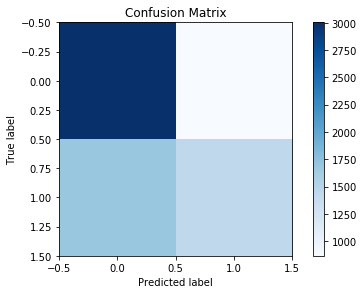


 Feature Importance
('hour_created', 0.08970201825117453)
('weekday_created', 0.056799215090794074)
('photo_exists', 0.02750066945634734)
('tweet_sentiment', 0.033220169458604884)
('retweets_per_followers', 0.32527634951148615)
('favs_per_followers', 0.22717834270903808)
('rate_all_caps', 0.08792094716832706)
('text_length', 0.1524022883542279)




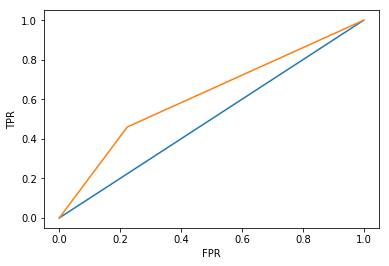

AUC:  0.6182968641096613


In [45]:
train_score(classifier=gbc, x=X, y=y)

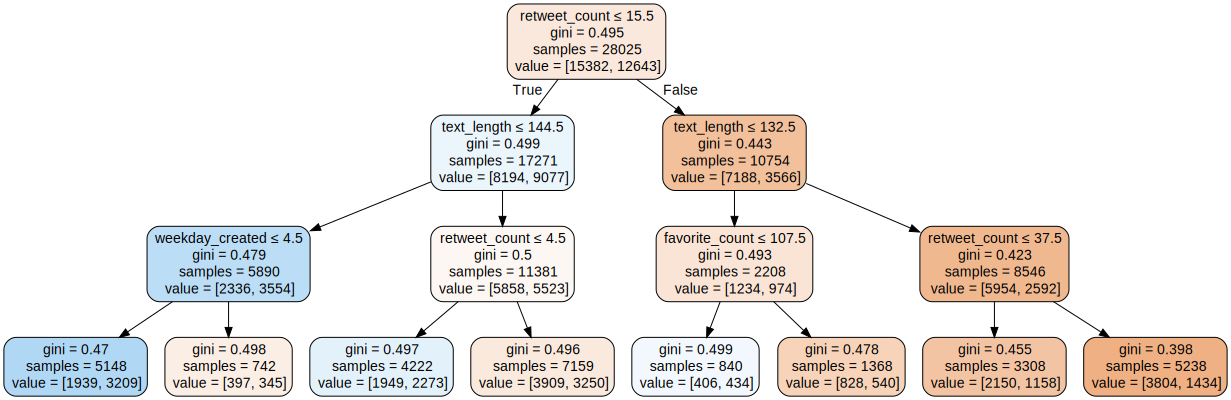

In [14]:
import graphviz 
from sklearn import tree

dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=X.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

In [15]:
X.columns

Index(['hour_created', 'weekday_created', 'photo_exists', 'tweet_sentiment',
       'retweet_count', 'favorite_count', 'text_length'],
      dtype='object')

In [16]:
toy_model = gbc.fit(X, y)

In [21]:
with open('../muffin_flask_example/toy_model.pkl', 'wb') as file:
    pickle.dump(toy_model, file)

In [18]:
import pickle

In [23]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35032 entries, 0 to 35300
Data columns (total 7 columns):
hour_created       35032 non-null int64
weekday_created    35032 non-null int64
photo_exists       35032 non-null int64
tweet_sentiment    35032 non-null int64
retweet_count      35032 non-null int64
favorite_count     35032 non-null int64
text_length        35032 non-null int64
dtypes: int64(7)
memory usage: 2.1 MB
